In [1]:
import caffe
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import caffe.draw
from caffe.proto import caffe_pb2
from google.protobuf import text_format
import cv2

In [2]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [3]:
caffe.set_mode_cpu()

Deploy network

In [15]:
net = caffe_pb2.NetParameter()
text_format.Merge(open(u'..\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\hier_autoencoder_fonts_deploy.prototxt').read(), net)
image_name = u'..\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\hier_autoencoder_deploy.png'
print('Drawing net to %s' % image_name)

phase = caffe.TRAIN
caffe.draw.draw_net_to_file(net, image_name, 'LR', phase)

Exception: "dot.exe" not found in path.

In [4]:
net = caffe.Net('..\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\hier_autoencoder_fonts_deploy.prototxt', '..\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\_iter_20000.caffemodel', caffe.TEST)

In [5]:
shapes = [(k, v.data.shape) for k, v in net.blobs.items()]
for shape in shapes:
    print shape

In [7]:
def inverse(image):
    
    width, height = image.size
    inverted_image = image.copy()
    for i in range(height):
        for j in range(width):
            inverted_image.putpixel((i, j), (255 - image.getpixel((i, j))))
            
    return inverted_image

In [19]:
font_directory = u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\test_fonts\\'
font_hiers = os.listdir(font_directory)

WindowsError: [Error 3] The system cannot find the path specified: u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\test_fonts\\*.*'

In [38]:
def load_font_image(hier):
    for font_hier in font_hiers:
        font_hier_name = int(font_hier[:font_hier.find(u'.')])
        if font_hier_name == hier:
            font_hier_image = Image.open(font_directory + font_hier)
            X = np.zeros((1, 1, 23, 23), dtype='f4') 
            X[0] = font_hier_image
            for i in range(X.shape[2]):
                for j in range(X.shape[3]):
                    X[0][0][i][j] = X[0][0][i][j] * 0.00392156862
            
            return X[0].flatten()

In [22]:
from random import shuffle

#input_directory = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Images\\simple_set_cropped_united_black_transformed\\'
input_directory = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Images\\network_inputs_black\\'
#input_directory = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Images\\network_inputs_black\\'

output_dir = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\gg_output_glyph\\'
input_save_dir = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Experiments\\2017.02.26_21960_font-font_1-4_-1-+1\\gg_input_glyph\\'

import scipy.misc

iteration = 0

file_list = os.listdir(input_directory)
shuffle(file_list)

errors = []

result_vectors = []

for filename in file_list[:1000]:
    image = Image.open(input_directory + filename)  
    
    inversed_image = inverse(image)
    #inversed_image.save(input_save_dir + filename, 'BMP')
    
    #image.save(input_save_dir + filename, 'BMP')
    
    X = np.zeros((1, 1, 23, 23), dtype='f4') 
    X[0] = image
    #print X[0], '\n'
    for i in range(X.shape[2]):
        for j in range(X.shape[3]):
            X[0][0][i][j] = (X[0][0][i][j]) * 0.00392156862
            
    input_vector = X[0].flatten()
    #print "input norm =", np.linalg.norm(input_vector)
    
    net.blobs['Input'].data[...] = X[0]
    
    net.forward()
    
    #print net.blobs['Input'].data, '\n'
    #print net.blobs['normalization'].data, '\n'
    
    result_vector = np.array(net.blobs['decode1neuron'].data, dtype='f4')
    
    result_vector = result_vector.flatten()
    
    #print "result norm =", np.linalg.norm(result_vector)
    #print "diff norm =", np.linalg.norm(input_vector - result_vector), "\n"
    
    #font_vector = load_font_image(int(filename[:filename.find(u'.')]))
    #errors.append(np.linalg.norm(font_vector - result_vector))
    
    errors.append(np.linalg.norm(input_vector - result_vector))
    
    for i in range(len(result_vector)):
        result_vector[i] = (1.0 - result_vector[i]) * 255
        #result_vector[i] = (result_vector[i]) * 255
    
    result_matrix = np.reshape(result_vector, (23, 23))
    #scipy.misc.imsave(output_dir + filename, result_matrix)
    
    iteration += 1

In [23]:
float(sum(errors) ) / len(errors)

6.766690993070602

In [42]:
float(sum(errors_train) ) / len(errors)

5.112538835287094

In [45]:
errors_test = errors

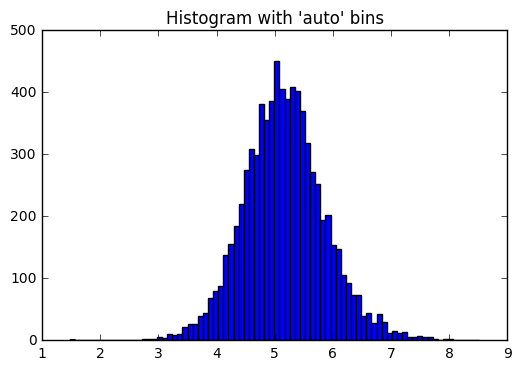

In [47]:
%inline

import matplotlib.pyplot as plt

plt.hist(errors_test, bins='auto', color='b')  # plt.hist passes it's arguments to np.histogram
plt.savefig('glyph-font-nn.jpg')
plt.title("Histogram with 'auto' bins")
plt.show()